In [1]:
from anndata import AnnData
from mudata import MuData
import numpy as np
import pandas as pd
from skimage.draw import disk
from tifffile import imread
import scanpy as sc
from vitessce.data_utils import (
    rgb_img_to_ome_tiff,
    multiplex_img_to_ome_tiff,
    rgb_img_to_ome_zarr,
    multiplex_img_to_ome_zarr,
    optimize_adata,
    VAR_CHUNK_SIZE,
)

In [2]:
img_arr = imread("/Users/mkeller/Downloads/exemplar-001.pyramid.ome.tif")

In [3]:
img_arr.shape

(12, 3138, 2509)

In [4]:
bitmask_arr = imread("/Users/mkeller/Downloads/cellMask.pyramid.ome.tif")

In [5]:
bitmask_arr.shape

(3138, 2509)

In [6]:
img_crop_arr = img_arr[0:4, 1000:1250, 1000:1250]

In [7]:
cells_bitmask_crop_arr = bitmask_arr[1000:1250, 1000:1250]

In [8]:
multiplex_img_to_ome_tiff(img_crop_arr, ["DNA", "FDX1", "CD1D", "CD357"], "/Users/mkeller/Downloads/exemplar-001.crop.ome.tif", axes='CYX')

In [9]:
multiplex_img_to_ome_zarr(img_crop_arr, ["DNA", "FDX1", "CD1D", "CD357"], "/Users/mkeller/Downloads/exemplar-001.crop.image.ome.zarr")

In [10]:
shapes_bitmask_crop_arr = np.zeros((250, 250))
radius = 5
for i in range(16):
    for j in range(16):
        disk_center = (10 + i*15, 10 + j*15)
        shapes_bitmask_crop_arr[disk(disk_center, radius)] = i*16+j+1 # add one (0 is reserved for the background)

# Update the array axes so they are in CYX order to enable conversion to OME-TIFF.
shapes_bitmask_crop_arr = shapes_bitmask_crop_arr.transpose((1, 0)) # (y, x)

In [11]:
multichannel_bitmask_arr = np.stack((cells_bitmask_crop_arr, shapes_bitmask_crop_arr))

In [12]:
multichannel_bitmask_arr.shape

(2, 250, 250)

In [13]:
multiplex_img_to_ome_tiff(multichannel_bitmask_arr, ["Cells", "Circles"], "/Users/mkeller/Downloads/exemplar-001.crop.segmentations.ome.tif", axes='CYX')

In [14]:
multiplex_img_to_ome_zarr(multichannel_bitmask_arr, ["cell", "circle"], "/Users/mkeller/Downloads/exemplar-001.crop.segmentations.ome.zarr")

In [15]:
cell_ids = np.unique(multichannel_bitmask_arr[0, :, :])[1:]

In [16]:
circle_ids = np.unique(multichannel_bitmask_arr[1, :, :])[1:]

In [17]:
cell_df = pd.DataFrame(index=cell_ids.astype(int), data=[], columns=[])

In [18]:
circle_df = pd.DataFrame(index=circle_ids.astype(int), data=[], columns=["X", "Y"])

In [19]:
for i in range(16):
    for j in range(16):
        c_x = 10 + i*15
        c_y = 10 + j*15
        c_index = int(i*16+j+1)
        circle_df.at[c_index, "X"] = c_x
        circle_df.at[c_index, "Y"] = c_y

In [20]:
cell_df

""
1006
1007
1011
1012
1018
...
2012
2016
2021
2023


In [21]:
multichannel_bitmask_arr[0, :, :]

array([[   0.,    0.,    0., ..., 1012., 1012., 1012.],
       [   0.,    0.,    0., ..., 1012., 1012., 1012.],
       [   0.,    0.,    0., ..., 1012., 1012., 1012.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [22]:
def get_centroid(bitmask_arr, obs_id):
    matching_px = np.argwhere(bitmask_arr == obs_id)
    count = matching_px.shape[0]
    result = matching_px.sum(0) / count
    return (result[0], result[1])

In [23]:
def get_channel_value(bitmask_arr, img_arr, obs_id):
    matching_px = (bitmask_arr == obs_id)
    matching_img = img_arr[matching_px]
    return matching_img.sum() / matching_px.sum()

In [24]:
get_channel_value(multichannel_bitmask_arr[0, :, :], img_crop_arr[0, :, :], 1011)

60204.72093023256

In [25]:
get_centroid(multichannel_bitmask_arr[0, :, :], 1006)

(1.55, 191.525)

In [26]:
var_df = pd.DataFrame(index=["DNA", "FDX1", "CD1D", "CD357"], data=[], columns=[])

In [27]:
cell_df["X"] = [get_centroid(multichannel_bitmask_arr[0, :, :], int(i))[0] for i in cell_df.index]
cell_df["Y"] = [get_centroid(multichannel_bitmask_arr[0, :, :], int(i))[1] for i in cell_df.index]

In [28]:
cell_df

,X,Y
1006,1.550000,191.525000
1007,1.930556,212.305556
1011,3.232558,48.581395
1012,1.363636,248.090909
1018,0.578947,156.631579
...,...,...
2012,247.225806,194.161290
2016,248.214286,217.785714
2021,248.857143,161.285714
2023,249.000000,66.000000


In [29]:
cell_X = np.zeros((cell_df.shape[0], var_df.shape[0]))

In [30]:
for c_index in range(4):
    for i, cell_id in enumerate(cell_df.index):
        cell_X[i, c_index] = get_channel_value(multichannel_bitmask_arr[0, :, :], img_crop_arr[c_index, :, :], cell_id)

In [31]:
adata = AnnData(X=cell_X, obs=cell_df, var=var_df)

/var/folders/36/83j6x3ln225bvbpk1_vdzrm00000gn/T/ipykernel_75334/3333765654.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(X=cell_X, obs=cell_df, var=var_df)
/Users/mkeller/software/miniconda3/envs/vitessce-python-notebooks/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
adata

AnnData object with n_obs × n_vars = 218 × 4
    obs: 'X', 'Y'

In [46]:
cell_types = [
    ["Astrocyte", "Astrocyte Gfap"],
    ["Astrocyte", "Astrocyte Mfge8"],
    ["Brain immune", "Microglia"],
    ["Brain immune", "Perivascular Macrophage"],
    ["Excitatory neurons", "Hippocampus"]
]
leiden_clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9]

adata.obs["cell_type_i"] = [ i % len(cell_types) for i in range(adata.obs.shape[0])]
adata.obs["cell_type_coarse"] = adata.obs["cell_type_i"].apply(lambda i: cell_types[i][0])
adata.obs["cell_type_fine"] = adata.obs["cell_type_i"].apply(lambda i: cell_types[i][1])
adata.obs["leiden_cluster"] = [ leiden_clusters[i % len(leiden_clusters)] for i in range(adata.obs.shape[0])]
adata.obs["leiden_cluster_str"] = [ f"Cluster {leiden_clusters[i % len(leiden_clusters)] for i in range(adata.obs.shape[0])]

In [47]:
adata.obs

,X,Y,cell_type_i,cell_type_coarse,cell_type_fine,leiden_cluster
1006,1.550000,191.525000,0,Astrocyte,Astrocyte Gfap,1
1007,1.930556,212.305556,1,Astrocyte,Astrocyte Mfge8,2
1011,3.232558,48.581395,2,Brain immune,Microglia,3
1012,1.363636,248.090909,3,Brain immune,Perivascular Macrophage,4
1018,0.578947,156.631579,4,Excitatory neurons,Hippocampus,5
...,...,...,...,...,...,...
2012,247.225806,194.161290,3,Brain immune,Perivascular Macrophage,7
2016,248.214286,217.785714,4,Excitatory neurons,Hippocampus,8
2021,248.857143,161.285714,0,Astrocyte,Astrocyte Gfap,9
2023,249.000000,66.000000,1,Astrocyte,Astrocyte Mfge8,1


/Users/mkeller/software/miniconda3/envs/vitessce-python-notebooks/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:1068: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


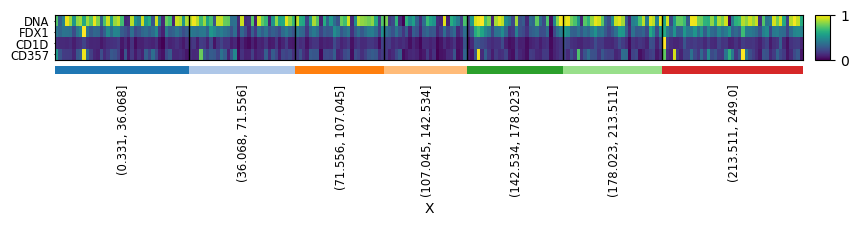

In [33]:
ax = sc.pl.heatmap(adata, var_names = var_df.index.tolist(), groupby="X", standard_scale="var", swap_axes=True)

In [34]:
adata.write_zarr("/Users/mkeller/Downloads/exemplar-001.crop.cells.adata.zarr")

In [35]:
circle_df

,X,Y
1,10,10
2,10,25
3,10,40
4,10,55
5,10,70
...,...,...
252,235,175
253,235,190
254,235,205
255,235,220


In [36]:
circle_adata = AnnData(X=None, obs=circle_df, var=pd.DataFrame(data=[]))

/Users/mkeller/software/miniconda3/envs/vitessce-python-notebooks/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/mkeller/software/miniconda3/envs/vitessce-python-notebooks/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [37]:
circle_adata.obs['X'] = circle_adata.obs['X'].astype(int)
circle_adata.obs['Y'] = circle_adata.obs['Y'].astype(int)

In [38]:
circle_adata.write_zarr("/Users/mkeller/Downloads/exemplar-001.crop.circles.adata.zarr")